In [1]:
import pandas as pd

DATASET_FILENAME = 'chicken_reviews/[맛있닭] 닭가슴살 스테이크.csv'

review_df = pd.read_csv(DATASET_FILENAME)
review_df.head()

,rating,review
0,5,잡채맛이라 밋밋하지 않고 질리지 않게 먹고 있어요!
1,5,닭가슴살 스테이크는 퍽퍽한게 사실인데\n맛있닭 제품은 퍽퍽보다는 쫄깃해요.\n단백질...
2,5,헬스 뉴비인데 갠적으로 닭가슴살 좋아해서 120g짜리 단백질25g프로 샀는데 맛있어...
3,5,냉동된거 앞 뒤로 전자레인지 1분씩 돌리면 쫄깃하고 정말 맛있습니다 매일 두개정도씩...
4,5,예전에 다른곳 닭가슴살 시켰다가..실패하고는 ..\n닭가슴살은 퍽퍽할 수 밖에 없나...


In [2]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2995 entries, 0 to 2994
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  2995 non-null   int64 
 1   review  2995 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


In [3]:
text_length_s = review_df['review'].map(len)
print('min:', text_length_s.min())
print('mean:', text_length_s.mean())
print('max:', text_length_s.max())

min: 10
mean: 57.468113522537564
max: 694


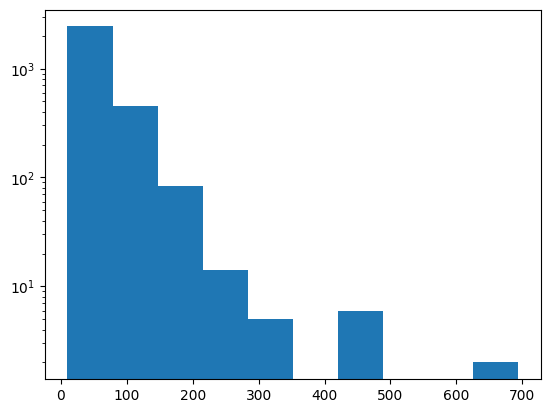

In [4]:
import matplotlib.pyplot as plt


plt.hist(text_length_s)
plt.yscale('log')
plt.show()

In [5]:
text = review_df['review'][2]
print(text)

헬스 뉴비인데 갠적으로 닭가슴살 좋아해서 120g짜리 단백질25g프로 샀는데 맛있어요 딱 기대한맛 그대로에요


In [6]:
review_df.groupby('rating').count()

,review
rating,
5,2995


In [7]:
import re


def preprocess(text):
    text = text.replace('\\n', ' ')
    text = re.sub(r'[^a-zA-Z0-9ㄱ-ㅎ가-힣 \w]+', '', text)

    return text


print(preprocess(text))

헬스 뉴비인데 갠적으로 닭가슴살 좋아해서 120g짜리 단백질25g프로 샀는데 맛있어요 딱 기대한맛 그대로에요


# 형태소 분석기 별 단어 빈도 분석
## SoyNLP

In [8]:
from soynlp.word import WordExtractor


reviews = review_df['review'].map(preprocess).to_list()

word_extractor = WordExtractor(min_frequency=1)
word_extractor.train(reviews)
words = word_extractor.extract()

training was done. used memory 0.196 Gbry 0.189 Gb
all cohesion probabilities was computed. # words = 15623
all branching entropies was computed # words = 15065
all accessor variety was computed # words = 15065


In [9]:
scores = cohesion_score = {word:score.cohesion_forward for word, score in words.items()}

In [10]:
from collections import Counter
from soynlp.tokenizer import MaxScoreTokenizer
from tqdm.notebook import tqdm


tokenizer = MaxScoreTokenizer(scores=scores)

word_freq = Counter()
for review in tqdm(reviews):
    tokens = tokenizer.tokenize(review)
    for token in tokens:
        count = word_freq.get(token, 0)
        word_freq[token] = count + 1

  0%|          | 0/2995 [00:00<?, ?it/s]

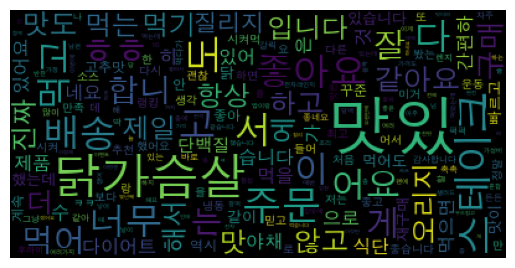

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


wc = WordCloud(font_path='AppleGothic.ttf')

plt.imshow(wc.generate_from_frequencies(word_freq))
plt.axis('off')

plt.show()

## KoNLPy Mecab

In [12]:
from konlpy.tag import Mecab


mecab = Mecab()

print(mecab.pos(reviews[0]))

[('잡채', 'NNG'), ('맛', 'NNG'), ('이', 'VCP'), ('라', 'EC'), ('밋밋', 'XR'), ('하', 'XSA'), ('지', 'EC'), ('않', 'VX'), ('고', 'EC'), ('질리', 'VV'), ('지', 'EC'), ('않', 'VX'), ('게', 'EC'), ('먹', 'VV'), ('고', 'EC'), ('있', 'VX'), ('어요', 'EF')]


In [13]:
ALLOWED_POS = ['NNG', 'NNP', 'NR', 'VV', 'VA', 'MAG', 'MAC']


def filter_by_pos(tokenizer, sentence):
    tokens_with_pos = tokenizer.pos(sentence)
    filtered_tokens = filter(lambda p: p[1] in ALLOWED_POS, tokens_with_pos)
    return [token for (token, _) in filtered_tokens]    

In [14]:
word_freq = Counter()
for review in tqdm(reviews):
    tokens = mecab.morphs(review)
    #tokens = filter_by_pos(mecab, review)
    for token in tokens:
        count = word_freq.get(token, 0)
        word_freq[token] = count + 1

  0%|          | 0/2995 [00:00<?, ?it/s]

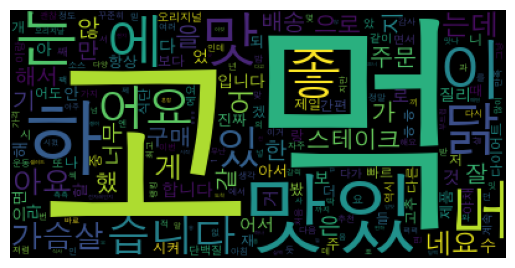

In [15]:
plt.imshow(wc.generate_from_frequencies(word_freq))
plt.axis('off')

plt.show()

## Kiwi

In [16]:
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords


kiwi = Kiwi()
stopwords = Stopwords()

In [17]:
kiwi.split_into_sents(reviews[0])

[Sentence(text='잡채맛이라 밋밋하지 않고 질리지 않게 먹고 있어요', start=0, end=27, tokens=None, subs=[])]

In [18]:
word_freq = Counter()

for review in reviews:
    for sentence in kiwi.split_into_sents(review):
        tokens = kiwi.tokenize(sentence.text, stopwords=stopwords)
        for token in filter(lambda t: t.tag in ALLOWED_POS, tokens):
            count = word_freq.get(token.form, 0)
            word_freq[token.form] = count + 1

In [19]:
word_freq.most_common(100)

[('먹', 3179),
 ('맛있', 1815),
 ('맛', 1328),
 ('좋', 1189),
 ('닭', 1140),
 ('가슴살', 939),
 ('스테이크', 637),
 ('주문', 599),
 ('잘', 510),
 ('너무', 479),
 ('배송', 478),
 ('구매', 437),
 ('있', 399),
 ('시키', 378),
 ('질리', 357),
 ('빠르', 357),
 ('안', 272),
 ('진짜', 249),
 ('제품', 246),
 ('항상', 235),
 ('다', 221),
 ('다이어트', 217),
 ('고추', 196),
 ('야채', 189),
 ('사', 187),
 ('제일', 187),
 ('식단', 183),
 ('단백질', 172),
 ('같이', 162),
 ('오리지널', 152),
 ('계속', 147),
 ('또', 145),
 ('역시', 144),
 ('꾸준히', 140),
 ('처음', 140),
 ('간편하', 140),
 ('가격', 137),
 ('이번', 136),
 ('최고', 135),
 ('정말', 133),
 ('오', 133),
 ('만족', 129),
 ('감사', 127),
 ('생각', 126),
 ('돌리', 125),
 ('운동', 125),
 ('편하', 125),
 ('괜찮', 121),
 ('들', 118),
 ('밥', 115),
 ('추천', 114),
 ('랭킹', 113),
 ('맞', 109),
 ('소스', 109),
 ('아침', 106),
 ('다시', 103),
 ('팩', 99),
 ('넣', 97),
 ('딱', 96),
 ('많이', 92),
 ('자주', 92),
 ('맛나', 90),
 ('정도', 89),
 ('그냥', 88),
 ('나', 87),
 ('갈릭', 86),
 ('넘', 85),
 ('바로', 84),
 ('끼', 83),
 ('오리지날', 81),
 ('아주', 79),
 ('살', 78),
 ('저렴하', 78)

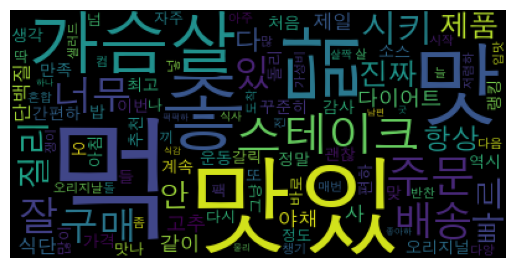

In [20]:
plt.imshow(wc.generate_from_frequencies(dict(word_freq.most_common(100))))
plt.axis('off')

plt.show()

# 관련 단어의 분포 확인하기

In [21]:
import os

import pandas as pd
from tqdm.notebook import tqdm


with open('corpus.txt', 'w') as f:
    for filename in tqdm(os.listdir('chicken_reviews/'), position=0):
        reviews_df = pd.read_csv('chicken_reviews/' + filename)

        for review in tqdm(reviews_df['review'], position=1):
            f.write(str(review) + '\n')

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/1550 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/2405 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/1155 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/2340 [00:00<?, ?it/s]

  0%|          | 0/2220 [00:00<?, ?it/s]

  0%|          | 0/4765 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/685 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/3075 [00:00<?, ?it/s]

  0%|          | 0/3905 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/3755 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/2995 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1305 [00:00<?, ?it/s]

In [22]:
from soynlp import DoublespaceLineCorpus
from soynlp.word import WordExtractor
from soynlp.tokenizer import MaxScoreTokenizer


corpus = DoublespaceLineCorpus('corpus.txt', iter_sent=True)

word_extractor = WordExtractor()
word_extractor.train(corpus)
words = word_extractor.extract()

scores = {word:score.cohesion_forward for word, score in words.items()}
tokenizer = MaxScoreTokenizer(scores=scores)

training was done. used memory 0.882 Gbse memory 0.871 Gb
all cohesion probabilities was computed. # words = 71150
all branching entropies was computed # words = 152323
all accessor variety was computed # words = 152323


In [23]:
from collections import Counter


word_freq = Counter()
for review in tqdm(corpus):
    tokens = tokenizer.tokenize(review)
    for token in tokens:
        count = word_freq.get(token, 0)
        word_freq[token] = count + 1

  0%|          | 0/100414 [00:00<?, ?it/s]

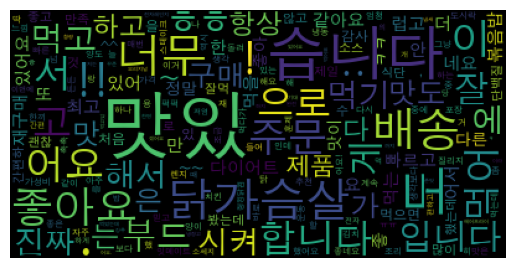

In [31]:
plt.imshow(wc.generate_from_frequencies(dict(word_freq.most_common(200)[1:])))
plt.axis('off')

plt.show()

In [25]:
from soynlp.word import pmi as pmi_func
from soynlp.vectorizer import sent_to_word_contexts_matrix


x, idx2vocab = sent_to_word_contexts_matrix(
    corpus,
    windows=3,
    min_tf=10,
    tokenizer=tokenizer,
    dynamic_weight=False,
    verbose=True
)

pmi, px, py = pmi_func(
    x,
    min_pmi = 0,
    alpha = 0.0,
    beta = 0.75
)

vocab2idx = {vocab:idx for idx, vocab in enumerate(idx2vocab)}

Create (word, contexts) matrix
  - counting word frequency from 100413 sents, mem=0.919 Gb
  - scanning (word, context) pairs from 100413 sents, mem=0.952 Gb
  - (word, context) matrix was constructed. shape = (6929, 6929)                    
  - done
8


In [47]:
def query_word_cloud(word, word_freq, pmi, vocab2idx, wc):
    query = vocab2idx[word]

    submatrix = pmi[query,:].tocsr() # get the row of query
    contexts = submatrix.nonzero()[1] # nonzero() return (rows, columns)
    pmi_i = submatrix.data

    most_relateds = [(idx, pmi_ij) for idx, pmi_ij in zip(contexts, pmi_i)]
    most_relateds = sorted(most_relateds, key=lambda x:-x[1])[:100]
    most_relateds = [(idx2vocab[idx], pmi_ij) for idx, pmi_ij in most_relateds]

    related_words = list(map(lambda x: x[0], most_relateds))

    related_word_freq = {word:freq for word, freq in word_freq.items() if word in related_words}
    related_word_freq = Counter(related_word_freq)

    plt.imshow(wc.generate_from_frequencies(dict(related_word_freq.most_common(207)[8:])))
    plt.axis('off')

    plt.show()

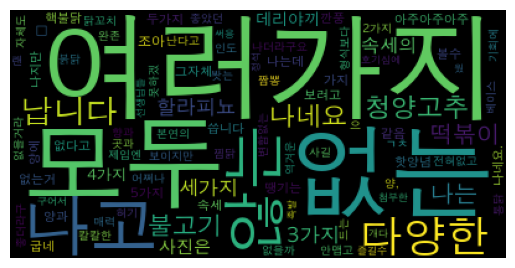

In [48]:
query_word_cloud('맛', word_freq, pmi, vocab2idx, wc)

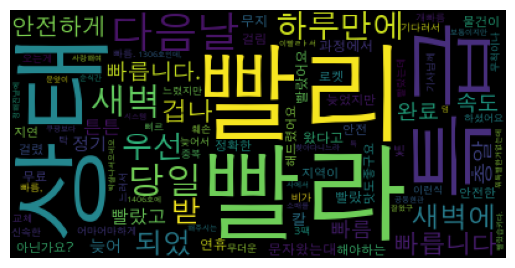

In [49]:
query_word_cloud('배송', word_freq, pmi, vocab2idx, wc)